# Lecture 13 - Symbolic Regression

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.add(
    [
        "OrdinaryDiffEq", 
        "DataDrivenDiffEq", 
        "DataDrivenSparse", 
        "Flux", 
        "Zygote", 
        "Optimisers", 
        "SciMLSensitivity", 
        "SymbolicRegression", 
        "Plots",
    ]
)

# Contents
1. [Housekeeping](#project)
2. [Recap: Deep Learning for Dynamical Systems](#recap)
3. [Estimating Equations from Data](#equations)
4. [SINDy: Sparse Identification of Nonlinear Dynamics](#sindy)
5. [SINDy Example: Lorenz System](#lorenz)
6. [A Harder Example: Estimating the Derivatives of Sparse Time Series with Neural ODEs](#neural-odes)
7. [Further Reading](#further-reading)

# 1. Housekeeping <a class="anchor" id="project"></a>

## Project Info - What's the Project?

* To pass this course, we ask you to work on a project.
<br>

* Work alone or in pairs (pairs are expected to do a slightly more extensive project).
<br>

* Work on a project that extends one of the topics from the lectures or picks up a new topic with the methods that we talked about, for example, exploring the dynamics of an extended version of one of the models we introduced in the lectures or combining one of the models with a machine learning method.
<br>

* We approve / hand out topics. Send us an **email by the end of next week** (alistair.white@tum.de, maximilian.gelbrecht@tum.de).
    * If you have an idea, please suggest it.
    * If you don't have an idea, name your favourite topics from the lecture and we will suggest something to you.<br>
<br>
* We will use the lecture/exercise on 3 February as an individual Q&A about the projects. We will send you your exact time.
 
## Handing in the Project

* The project is comprised of:
    * A short report (max. 5 pages) that introduces your topic, gives a short summary of the research history of the topic, the method/model that you use, and a short discussion of your results.
    * Code. Invite us to a Git repository with the codebase. Write your projects as scripts/notebooks with a Julia package that implements the code. The package should fulfil the usual Julia package requirements and include CI/CD, such as automated testing.<br>
<br>

* We offer an (optional) initial review of your project with short feedback. Deadline 10th March. We strongly recommend that you use this opportunity.
    * Don't expect us to bugfix your code, but we will try to help you if something is going wrong.<br>
<br>

* Hand in the completed project by **24th March**.
<br>

* If you cannot make these deadlines for a good reason, please inform us about it early!
<br>

* Indicate if you want to have a grade or just pass the course.

## 10 Minutes: Lecture Survey
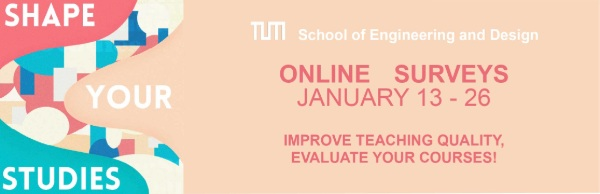

# 2. Recap: Deep Learning for Dynamical Systems <a class="anchor" id="recap"></a>

* In the last three lectures we used Artificial Neural Networks (ANNs) to estimate dynamical systems.
<br>

* Suppose we have a dynamical system,
$$\frac{d\mathbf{x}}{dt} = f(\mathbf{x},t;\theta),$$
and observations $\mathbf{X}=\{\mathbf{x}(t_i)\}$ for $i\in[1;N-1]$. In the beginning, we will restrict ourselves to evenly sampled observations $t_i = i\cdot\Delta t$.
<br>

* The corresponding discretized dynamical system is $$\mathbf{x}_{i+1} = g(\mathbf{x}_i, t_i; \theta)$$ where $g$ is one iteration of some numerical DE solver.
<br>

* With **neural differential equations** (NDEs), we replaced $f$ with an ANN and used it as a universal function approximator to learn the right hand side of the dynamical system from the observations $\mathbf{X}$.
    * In order for this to work, we needed a differentiable DE solver, so we could take derivatives of solutions of the dynamical system, e.g., via adjoint sensitivity analysis.<br><br>
    
* With **recurrent neural networks** (RNNs) like **reservoir computers**, we replace $g$ with an ANN and learn it from data.
    * Reservoir computing simplifies RNNs to use a very large hidden layer that is not trainable, instead training only the output layer.

# 3. Estimating Equations from Data <a class="anchor" id="equations"></a>

- Another approach for learning dynamical systems is to directly estimate the equations of motion from data, so that we actually reconstruct the symbolic expression of $f$ rather than just numerically approximating $f$ with a function approximator such as an ANN.
<br>

- There are several approaches to this, here we will group them in two categories:

## 3.1. Fitting the data to models that already have a certain analytical form (often done in System Identification)
 
- Most regression tasks fall into this category, including ANNs.
<br>

- But it's difficult to really learn something about the dynamics from ANNs for some application.
<br>

- Other candidate models include e.g. nonlinear autoregressive moving average processes (NARMA).
<br>

- One particularly popular model for climate dynamics is Emperical Model Reduction ([S. Kravtsov, D. Kondrashov, and M. Ghil](https://journals.ametsoc.org/view/journals/clim/18/21/jcli3544.1.xml)).
     - Primarly intended for stochastic systems 
     - Multi-level linear regression 
     - It has been succesfully applied e.g. to the El Niño Southern Oscillation 
     - Often one pre-processes the data with a principal component analysis and tries to model the data with a nested iterative regression 
        
       
## 3.2. Symbolic Regression

* Instead of already prescriping the functional form in a concrete way, can't we also let an algorithm find the functional form? 
<br>

* Symbolic Regression tries to find the mathematical expression that best fits the data $\mathbf{X}$.
<br>

* Applied to dynamical systems, it usually tries to find the mathematical expression for the right hand side $f$ of the equations of motion.
<br>

* Therefore we often also need derivative data (e.g. computed with finite differences).
<br>

* Symbolic regression approaches often provide a dictionary of possible expressions (e.g. polynomials up to a certain degree, trigonometric functions, etc.) and then performs a regression to determine the coefficients or parameters of these elementary functions.
<br>

* But there are infintely many combinations of expressions: 

![Symbolic Regression](assets/slice2.jpg)

* Most natural laws and equations involve just a handful of terms; a candidate model should be complex enough to replicate the behaviour of the system but also "simple" (see [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor)).
<br>

* Therefore, we often apply some form of sparsity constraint to the regression and consider only certain operations and expressions.
<br>

* [AI Feynman by Udrescu and Tegmark](https://arxiv.org/abs/1905.11481) attracted some attention: they do a symbolic regression with several different pre- and post-processing steps and apply it successfully to Feynman's lectures on physics.
<br>    

* All of these methods have limitations when the complexity of the problem increases, for example, as the data gets noisy and high-dimensional.
<br>
* One reason: There are just too many possible combinations of expressions to be considered.

# 4. SINDy: Sparse Identification of Nonlinear Dynamics <a class="anchor" id="sindy"></a>

- SINDy ([Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113)) is one of the most commonly used algorithms for identifying nonlinear dynamical systems.
<br>

- SINDy bypasses the intractable combinatorial search through all possible model structures by leveraging the fact that many dynamical systems,

$$\frac{d}{dt}\mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t)),$$


have only a few active terms in the space of possible right-hand side functions, c.f. the Lorenz system:

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z .
\end{aligned}
$$

- SINDy therefore attempts to fit a **sparse** model of the form,

$$f_k(\mathbf{x}) \approx \theta_k(\mathbf{x})^T \xi_k,$$

where $k = 1 \ldots N$ is the dimension of the problem, $\theta_k(\mathbf{x})^T$ is a vector of basis functions evaluated at $\mathbf x$, and $\xi_k$ are the sparse coefficients determining which elements of $\theta_k(\mathbf{x})$ are "active" in each equation of $\mathbf{f}(\mathbf{x})$.

- In matrix form,

$$\mathbf{f}(\mathbf{x}) \approx \mathbf{\Theta}(\mathbf{x})\mathbf{\Xi}.$$

- **The task of the SINDy algorithm is to find the sparse matrix of coefficients $\mathbf{\Xi}$**.

## Step 1: Collect the Data

- Given observations at times $t_1, t_2, \ldots, t_m$, construct two data matrices $\mathbf X$ and $\mathbf{\dot X}$:

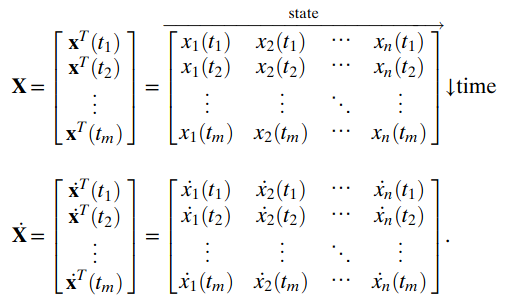


- If measurements of $\mathbf{\dot x}$ are not available, they can be estimated from $\mathbf x$, e.g. via the total-variation regularized derivative (a kind of regularised finite differences).

## Step 2: Construct a Library of Candidate Nonlinear Functions

- Given $\mathbf X$, construct a library of candidate functions $\mathbf{\Theta{(X)}}$,

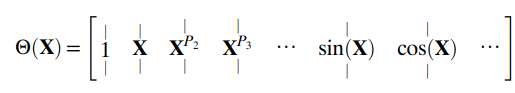

where $\mathbf{X}^{P_i}$ denotes all polynomials of degree $i$, i.e.

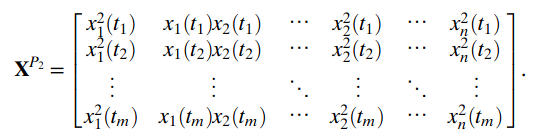

- When constructing $\mathbf{\Theta{(X)}}$, the world is your oyster. Common choices of candidate basis functions would include constant, polynomial, and trigonometric terms, but you can add columns for any functions you like.

## Step 3: Set Up a Sparse Regression Problem

- Given the prior that only a few of the candidate functions will be "active" in each component of $\mathbf{f}$, we can set up the sparse regression problem

$$\mathbf{\dot{X}} = \mathbf{\Theta{(X)}}\mathbf{\Xi},$$

where $\mathbf{\Xi} = [\mathbf{\xi_1} \; \mathbf{\xi_2} \cdots \mathbf{\xi_n}]$ are the sparse coefficients to be determined.

## Step 4: Solve the Sparse Regression Problem

- A common sparse regression method is [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)), which uses an $l_1$ norm, but this may be slow for large amounts of data.
<br>

- Instead, the SINDy authors use a **sequentially thresholded least squares algorithm**, with the following steps:
    1. Begin with a standard least-squares solution for $\mathbf{\Xi}$.
    2. Set all coefficients with magnitude less than the threshold parameter $\lambda$ equal to zero.
    3. Repeat the least-squares solution on the remaining "active" variables.
    4. Return to step 2 (terminating when the non-zero coefficients have converged).

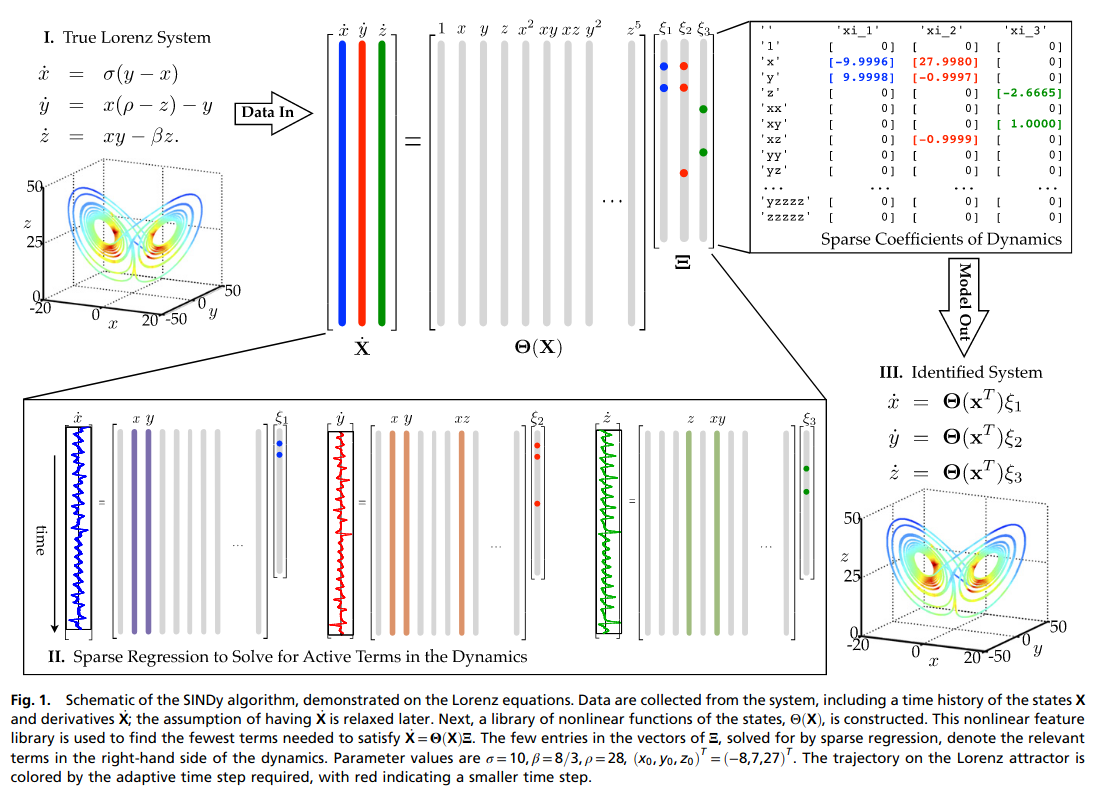

# 5. SINDy Example: Lorenz System <a class="anchor" id="lorenz"></a>

- The Julia package [DataDrivenDiffEq.jl](https://docs.sciml.ai/DataDrivenDiffEq/stable/#DataDrivenDiffEq.jl) provides utilities for estimating models from data.
<br>

- It can be used in combination with the related package [DataDrivenSparse.jl](https://docs.sciml.ai/DataDrivenDiffEq/stable/libs/datadrivensparse/sparse_regression/#DataDrivenSparse) for SINDy.

In [35]:
using OrdinaryDiffEq, DataDrivenDiffEq, DataDrivenSparse, Plots

## Step 1: Set Up the Training Data

In [36]:
function lorenz(u, p, t)
    x, y, z = u

    dx = 10.0 * (y - x)
    dy = x * (28.0 - z) - y
    dz = x * y - (8/3) * z
    
    return [dx, dy, dz]
end

lorenz (generic function with 1 method)

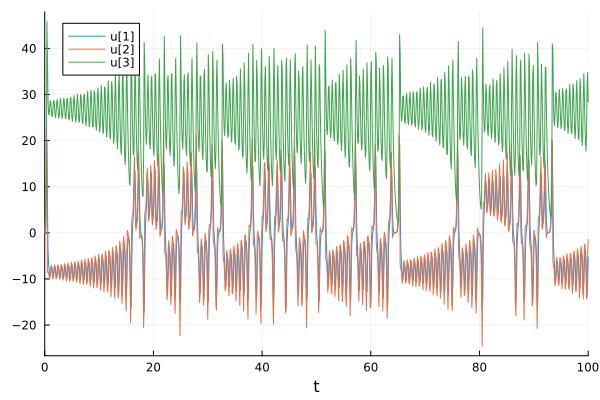

In [37]:
u0 = [1.0, 0.0, 0.0]
tspan = (0.0, 100.0)
dt = 0.1
prob = ODEProblem(lorenz, u0, tspan)
sol = solve(prob, Tsit5(), saveat = dt)
plot(sol)

## Step 2: Set up the Data-Driven Problem Object
- For convenience, we can directly construct `DataDrivenProblem` using an `ODESolution` object, but many more [constructors](https://docs.sciml.ai/DataDrivenDiffEq/stable/problems/) are available. 

In [38]:
ddprob = DataDrivenProblem(sol)

Continuous DataDrivenProblem{Float64} ##DDProblem#264 in 3 dimensions and 1001 samples

## Step 3: Define the Library of Candidate Nonlinear Basis Functions

In [39]:
@variables t x(t) y(t) z(t)  # Symbolic variables
u = [x, y, z]
basis = Basis(polynomial_basis(u, 5), u, iv = t)  # iv: independent variable

Model ##Basis#265:
Equations (56):
  56 standard: see equations(##Basis#265)
Unknowns (3): see unknowns(##Basis#265)
  x(t)
  y(t)
  z(t)

## Step 4: Set Up the Optimiser

In [40]:
optimiser = STLSQ(exp10.(-5:0.1:-1))

STLSQ{Vector{Float64}, Float64}([1.0e-5, 1.2589254117941661e-5, 1.584893192461114e-5, 1.9952623149688786e-5, 2.5118864315095822e-5, 3.1622776601683795e-5, 3.9810717055349695e-5, 5.011872336272725e-5, 6.309573444801929e-5, 7.943282347242822e-5  …  0.012589254117941675, 0.015848931924611134, 0.0199526231496888, 0.025118864315095794, 0.03162277660168379, 0.039810717055349734, 0.05011872336272722, 0.06309573444801933, 0.07943282347242814, 0.1], 0.0)

## Step 5: Solve

In [41]:
ddsol = solve(ddprob, basis, optimiser, options = DataDrivenCommonOptions(digits = 1))

"DataDrivenSolution{Float64}"

In [42]:
ddsol.basis

Model ##Basis#268:
Equations (3):
  3 standard: see equations(##Basis#268)
Unknowns (3): see unknowns(##Basis#268)
  x(t)
  y(t)
  z(t)
Parameters (7): see parameters(##Basis#268)
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
  ⋮

In [43]:
ddsol.prob.p

7-element Vector{Float64}:
 -10.0
  10.0
  28.0
  -1.0
  -0.9
   0.9
  -2.6

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z .
\end{aligned}
$$


* We can also make use of the solution object directly to integrate the fitted system:

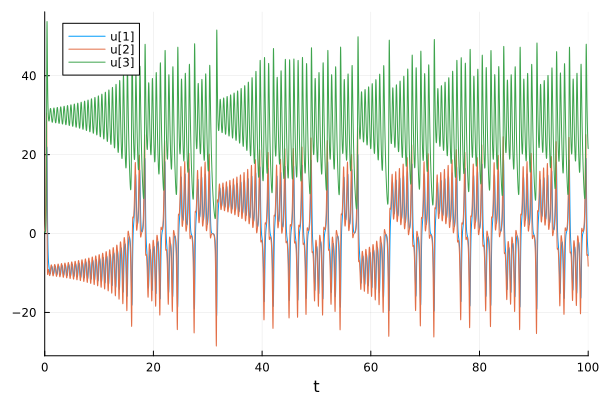

In [44]:
u0 = rand(3)
tspan = (0.0, 100.0)
prob_sindy = ODEProblem((u,p,t) -> ddsol(u,p,t), u0, tspan, ddsol.prob.p)
sol_sindy = solve(prob_sindy, Tsit5())
plot(sol_sindy)

# 6. A Harder Example: Estimating the Derivatives of Sparse Time Series with Neural ODEs <a class="anchor" id="neural-odes"></a>

In [45]:
using OrdinaryDiffEq
using Flux
using Zygote
using Optimisers
using SciMLSensitivity
using SymbolicRegression
using Statistics
using Plots

- The SINDy algorithm relies on two important assumptions:
    1. We can either observe the derivatives $\mathbf{\dot x}$, or the observations $\mathbf x$ are sufficiently densely packed that $\mathbf{\dot x}$ can be estimated, e.g. via finite differences.
    2. The underlying equations can be expressed as a linear combination of some pre-selected features.
<br><br>

- To get around the first assumption, we can use $\mathbf x$ to learn some $\dot{\mathbf x} = f = f_{\theta}$ as a neural network, i.e. a neural ODE.
<br>

- To get around the second assumption, we can use a more general symbolic regression algorithm, e.g. the equation search of [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl) which is based on [regularised evolution](https://arxiv.org/abs/1802.01548), a kind of [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm).
<br>

- We'll follow the example of [Kidger (2022)](https://arxiv.org/abs/2202.02435) - except we will use orders of magnitude less data - and consider the nonlinear oscillator

$$
\begin{equation}
    \begin{aligned}
        \dot x(t) &= \frac{y(t)}{1+y(t)} \\
        \dot y(t) &= \frac{-x(t)}{1+x(t)},
    \end{aligned}
\end{equation}
$$

for $t \in [0, T]$.

## Step 1: Generate the Training Data

In [46]:
function f(u, p, t)
    x, y = u
    
    dx = y / (1 + y)
    dy = -x / (1 + x)
    
    return [dx, dy]
end

f (generic function with 1 method)

In [47]:
u0 = -0.6f0 .+ (1.6f0 .* rand(Float32, 2))  # Randomly sampled from Uniform[-0.6, 1.0]
tspan = (0f0, 10f0)
dt = 0.1f0
prob = ODEProblem(f, u0, tspan)
sol = solve(prob, Tsit5(); saveat = dt)
ground_truth = Array(sol)

2×101 Matrix{Float32}:
 0.872993  0.919504  0.964608  1.00819   …   0.372319   0.155006  -0.0756316
 0.893146  0.845881  0.797372  0.747713     -0.673146  -0.693964  -0.69739

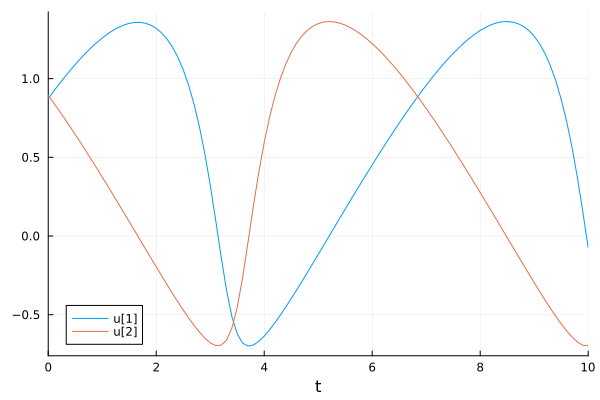

In [48]:
plot(sol)

## Step 2: Set Up the Neural ODE

- Now we need to estimate $f_{\theta}$ in order to find $\dot{\mathbf{x}}$ from $\mathbf{x}$.
<br>

- We'll use a multilayer perceptron with two fully-connected hidden layers with 64 hidden units and ReLU activation functions.

In [49]:
nn = Chain(Dense(2, 64, Flux.relu), Dense(64, 64, Flux.relu), Dense(64, 2))
θ, re = Optimisers.destructure(nn)

(Float32[0.19073376, -0.13509098, -0.10838364, 0.12099009, -0.14338107, -0.17020947, 0.08644187, 0.13605389, -0.0012307586, 0.15134877  …  -0.028191963, -0.20358463, -0.110956654, 0.15200832, -0.19294591, -0.14579983, 0.29678813, -0.2428468, 0.0, 0.0], Restructure(Chain, ..., 4482))

In [50]:
f_neural(u, θ, t) = re(θ)(u)
prob_neural = ODEProblem(f_neural, u0, tspan, θ)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 10.0f0)
u0: 2-element Vector{Float32}:
 0.87299347
 0.8931463

## Step 3: Set Up the Optimiser

- We'll use an Adam optimiser with a constant learning rate of 3e-3.

In [51]:
opt_rule = Optimisers.Adam(3e-3)
opt_state = Optimisers.setup(opt_rule, θ)

Leaf(Adam(0.003, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))

## Step 4: Set Up the Loss Function

- We'll use a standard MSE loss function without regularisation.

In [52]:
MSE(ground_truth, predicted) = mean(abs2, ground_truth .- predicted)

MSE (generic function with 1 method)

## Step 5: Train the Neural ODE

- Unlike most of the time series we've dealt with during this lecture course, the nonlinear oscillator isn't chaotic, so we can probably take gradients through the entire trajectory without any issues.
<br>

- Different initialisations of the neural network weights can lead to different results for this procedure. If you can't get the training loss to $\mathcal{O}(10^{-5})$, try:
    1. Training for more iterations.
    2. Re-initialising the neural network weights and starting again.
    3. Training on a small portion of the time series first before moving on to the entire time series.

In [54]:
n_iters = 3_000

3000

In [55]:
for i in 1:n_iters    
    training_loss, gradients = Zygote.withgradient(θ) do θ
        sol_neural = solve(prob_neural, Tsit5(), saveat = sol.t, p = θ)
        predicted = Array(sol_neural)
        return MSE(ground_truth, predicted)
    end
        
    Optimisers.update!(opt_state, θ, gradients[1])
    
    if (i % 100) == 0
        @info "Epoch = $(i), training loss = $(training_loss)"
    end
end

[ Info: Epoch = 100, training loss = 0.41563764
[ Info: Epoch = 200, training loss = 0.4083145
[ Info: Epoch = 300, training loss = 0.06452943
[ Info: Epoch = 400, training loss = 0.00084617053
[ Info: Epoch = 500, training loss = 0.00040641788
[ Info: Epoch = 600, training loss = 0.00058766274
[ Info: Epoch = 700, training loss = 0.0003217663
[ Info: Epoch = 800, training loss = 0.0016980724
[ Info: Epoch = 900, training loss = 0.00038041908
[ Info: Epoch = 1000, training loss = 0.00013486412
[ Info: Epoch = 1100, training loss = 0.00069966906
[ Info: Epoch = 1200, training loss = 0.00017060996
[ Info: Epoch = 1300, training loss = 8.902679e-5
[ Info: Epoch = 1400, training loss = 0.00027483373
[ Info: Epoch = 1500, training loss = 4.2248936e-5
[ Info: Epoch = 1600, training loss = 0.00016208878
[ Info: Epoch = 1700, training loss = 0.0035768172
[ Info: Epoch = 1800, training loss = 0.00015662906
[ Info: Epoch = 1900, training loss = 0.00075004005
[ Info: Epoch = 2000, training loss =

## Step 6: Use the Neural ODE to Predict $\dot{\mathbf{X}}$

In [56]:
x = ground_truth

2×101 Matrix{Float32}:
 0.872993  0.919504  0.964608  1.00819   …   0.372319   0.155006  -0.0756316
 0.893146  0.845881  0.797372  0.747713     -0.673146  -0.693964  -0.69739

In [57]:
mlp = re(θ)
dx = mlp(x)

2×101 Matrix{Float32}:
  0.45997    0.450082   0.440399  …  -1.99857   -2.19391   -2.2333
 -0.466672  -0.480216  -0.492552     -0.268539  -0.194451   0.0604033

## Step 7: Use [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl) to Find the Equation

- First we set up the options for the equation search. To keep things simple for the lecture, we limit ourselves to basic binary operations.
<br>

- See [here](https://astroautomata.com/SymbolicRegression.jl/stable/api/#Options) for a full specification of the possible options.

In [58]:
options = SymbolicRegression.Options(
    binary_operators=[+, *, /, -],
    unary_operators=[],
)

Options(binops=(+, *, /, -), unaops=(), bin_constraints=[(-1, -1), (-1, -1), (-1, -1), (-1, -1)], una_constraints=Int64[], complexity_mapping=SymbolicRegression.CoreModule.OptionsStructModule.ComplexityMapping{Int64, Int64}(false, Int64[], Int64[], 0, 0), tournament_selection_n=15, tournament_selection_p=0.982, parsimony=0.0, dimensional_constraint_penalty=nothing, dimensionless_constants_only=false, alpha=3.17, maxsize=30, maxdepth=30, turbo=Val{false}(), bumper=Val{false}(), migration=true, hof_migration=true, should_simplify=true, should_optimize_constants=true, output_directory=nothing, populations=31, perturbation_factor=0.129, annealing=true, batching=false, batch_size=50, mutation_weights=..., crossover_probability=0.0259, warmup_maxsize_by=0.0, use_frequency=true, use_frequency_in_tournament=true, adaptive_parsimony_scaling=1040.0, population_size=27, ncycles_per_iteration=380, fraction_replaced=0.00036, fraction_replaced_hof=0.0614, topn=12, verbosity=nothing, v_print_precisio

- Given the options we perform the equation search. 
<br>

- The results are stored in a `HallOfFame` object, which records the best equations seen during the equation search.

score = log2(loss) + complexity

In [59]:
hall_of_fame = EquationSearch(
    x,
    dx,
    niterations=100, 
    options=options,  # What operations are allowed
    parallelism=:multithreading,
)

[ Info: Started!



Expressions evaluated per second: 1.850e+05
Progress: 1084 / 6200 total iterations (17.484%)
════════════════════════════════════════════════════════════════════════════════════════════════════
Best equations for output 1
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.521e-01  1.594e+01  y₁ = x₂
3           1.573e-01  4.030e-01  y₁ = x₂ + -0.44142
5           7.682e-04  2.661e+00  y₁ = x₂ / (x₂ - -1.0072)
7           7.192e-04  3.298e-02  y₁ = (x₂ * 1.0227) / (x₂ - -1.0154)
9           6.484e-04  5.177e-02  y₁ = (0.62207 / ((0.61063 / x₂) + 0.59548)) - 0.011524
11          6.078e-04  3.235e-02  y₁ = 0.73661 / (((0.71161 / x₂) + (x₂ * 0.037422)) + 0.71...
                                       517)
13          6.015e-04  5.239e-03  y₁ = ((0.76824 / ((0.70589 / x₂) + 0.67138)) + (x₂ * -0.0...
                                       5067)) - 0.0041665
15          5.399e-04  5.402e


Expressions evaluated per second: 1.860e+05
Progress: 3092 / 6200 total iterations (49.871%)
════════════════════════════════════════════════════════════════════════════════════════════════════
Best equations for output 1
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.521e-01  1.594e+01  y₁ = x₂
3           1.573e-01  4.030e-01  y₁ = x₂ + -0.44142
5           7.682e-04  2.661e+00  y₁ = x₂ / (x₂ - -1.0072)
7           7.192e-04  3.298e-02  y₁ = (x₂ * 1.0227) / (x₂ - -1.0154)
9           6.484e-04  5.177e-02  y₁ = (0.73358 / ((0.7203 / x₂) + 0.70254)) + -0.01141
11          6.078e-04  3.237e-02  y₁ = 0.74347 / ((x₂ * 0.040756) + ((0.71707 / x₂) + 0.722...
                                       05))
13          6.009e-04  5.679e-03  y₁ = (x₂ * -0.04423) + ((0.76793 / ((0.7118 / x₂) + 0.679...
                                       15)) - 0.0053329)
15          4.858e-04  1.063e-0


Expressions evaluated per second: 1.720e+05
Progress: 4842 / 6200 total iterations (78.097%)
════════════════════════════════════════════════════════════════════════════════════════════════════
Best equations for output 1
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.521e-01  1.594e+01  y₁ = x₂
3           1.573e-01  4.030e-01  y₁ = x₂ + -0.44142
5           7.682e-04  2.661e+00  y₁ = x₂ / (x₂ - -1.0072)
7           7.192e-04  3.298e-02  y₁ = (x₂ * 1.0227) / (x₂ - -1.0154)
9           6.484e-04  5.181e-02  y₁ = (0.66072 / ((0.64873 / x₂) + 0.63284)) + -0.011398
11          6.077e-04  3.239e-02  y₁ = 0.75396 / ((x₂ * 0.038706) + ((0.72824 / x₂) + 0.732...
                                       13))
13          5.956e-04  1.007e-02  y₁ = (x₁ * 0.012655) + ((0.74581 / ((0.72654 / x₂) + 0.70...
                                       374)) - 0.023577)
15          4.732e-04  1.150e

───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.521e-01  1.594e+01  y₁ = x₂
3           1.573e-01  4.030e-01  y₁ = x₂ + -0.44142
5           7.682e-04  2.661e+00  y₁ = x₂ / (x₂ - -1.0072)
7           7.192e-04  3.298e-02  y₁ = 0.63426 / ((0.62969 / x₂) + 0.62016)
9           6.115e-04  8.105e-02  y₁ = x₂ * ((1.1645 / (x₂ - -1.0559)) + -0.063076)
11          6.045e-04  5.836e-03  y₁ = (((1.1625 / (x₂ - -1.0568)) + -0.058263) * x₂) + -0....
                                       0041209
13          5.956e-04  7.393e-03  y₁ = (x₁ * 0.012655) + ((0.74581 / ((0.72654 / x₂) + 0.70...
                                       374)) - 0.023577)
15          4.419e-04  1.492e-01  y₁ = 0.39413 / (((0.46699 / (x₂ * 1.1847)) + (0.0013457 /...
                                        (x₁ + 0.68501))) + 0.38789)
17          3.481e-04  1.192e-01  y₁ = (0.40418 / (((0.0022864 / (x₁ + 0.68993)) + (0.

[ Info: Final populations:
[ Info: Output 1:
[ Info: Output 2:
[ Info: Results saved to:


2-element Vector{HallOfFame{Float32, Float32, Expression{Float32, Node{Float32}, @NamedTuple{operators::DynamicExpressions.OperatorEnumModule.OperatorEnum{Tuple{typeof(+), typeof(*), typeof(/), typeof(-)}, Tuple{}}, variable_names::Vector{String}}}}}:
 HallOfFame{Float32, Float32, Expression{Float32, Node{Float32}, @NamedTuple{operators::DynamicExpressions.OperatorEnumModule.OperatorEnum{Tuple{typeof(+), typeof(*), typeof(/), typeof(-)}, Tuple{}}, variable_names::Vector{String}}}}(PopMember{Float32, Float32, Expression{Float32, Node{Float32}, @NamedTuple{operators::DynamicExpressions.OperatorEnumModule.OperatorEnum{Tuple{typeof(+), typeof(*), typeof(/), typeof(-)}, Tuple{}}, variable_names::Vector{String}}}}[PopMember(tree = (x2), loss = 0.35212636f0, score = 0.52996695f0), PopMember(tree = (0.0), loss = Inf32, score = 0.0f0), PopMember(tree = (x2 + -0.4414246), loss = 0.15727012f0, score = 0.23669901f0), PopMember(tree = (0.0), loss = Inf32, score = 0.0f0), PopMember(tree = (x2 / (x2 

- Given the "hall of fame", calculate the Pareto frontier for each equation, i.e. the best solution at each level of complexity.

In [60]:
pareto1 = calculate_pareto_frontier(x, dx[1, :], hall_of_fame[1], options)
pareto1[3].tree

x2 / (x2 - -1.0072007)

In [61]:
pareto2 = calculate_pareto_frontier(x, dx[2, :], hall_of_fame[2], options)
pareto2[3].tree

x1 / (-1.0051736 - x1)

- Just like that, we've recovered the equations for the nonlinear oscillator!

## Step 8 (just for fun): More Gradient Descent to Refine the Parameters...?

- In Kidger's example, he now does another round of gradient descent on the coefficients found by the symbolic regression in order to fine-tune them further.
<br>

- Our results are already extremely accurate, but if you really wanted to, this is how you'd do it...

In [62]:
function f_symbolic(u, p, t)
    x, y = u
    a, b = p
    
    dx = y / (a + y)
    dy = -x / (b + x)
    
    return [dx, dy]
end

f_symbolic (generic function with 1 method)

In [63]:
# Use 64-bit arithmetic for more precision
p = [1.0072007, 1.0051736]
u0_64 = Float64.(u0)
tspan_64 = Float64.(tspan)
prob_symbolic = ODEProblem(f_symbolic, u0_64, tspan_64, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 0.8729934692382812
 0.893146276473999

In [66]:
opt_rule = Optimisers.Adam(1e-5)
opt_state = Optimisers.setup(opt_rule, p)

Leaf(Adam(1.0e-5, (0.9, 0.999), 1.0e-8), ([0.0, 0.0], [0.0, 0.0], (0.9, 0.999)))

In [67]:
for i in 1:10_000
    training_loss, gradients = Zygote.withgradient(p) do p
        predicted = Array(solve(prob_symbolic, Tsit5(), saveat = sol.t, p = p))
        return MSE(ground_truth, predicted)
    end
        
    Optimisers.update!(opt_state, p, gradients[1])
    
    if (i % 200) == 0
        @info "Epoch = $(i), training loss = $(training_loss)"
        @info p
    end
end

[ Info: Epoch = 200, training loss = 0.00017294569774376555
[ Info: [0.9962707209190332, 0.9984585658992631]
[ Info: Epoch = 400, training loss = 0.00017294278492255928
[ Info: [0.9962699426601194, 0.9984593352218868]
[ Info: Epoch = 600, training loss = 0.00017294226839508145
[ Info: [0.9962696923882257, 0.9984595857329162]
[ Info: Epoch = 800, training loss = 0.00017294213215577519
[ Info: [0.9962696461180363, 0.9984596309107238]
[ Info: Epoch = 1000, training loss = 0.00017294213901463188
[ Info: [0.9962696408065844, 0.9984596357969902]
[ Info: Epoch = 1200, training loss = 0.00017294213902905033
[ Info: [0.9962696405152914, 0.9984596361379146]
[ Info: Epoch = 1400, training loss = 0.000172942192012071
[ Info: [0.9962696403532632, 0.9984596359977099]
[ Info: Epoch = 1600, training loss = 0.00017294219131128912
[ Info: [0.9962696404723451, 0.9984596361088822]
[ Info: Epoch = 1800, training loss = 0.00017294214024009505
[ Info: [0.9962696404524061, 0.9984596361020053]
[ Info: Epoch = 

[ Info: Epoch = 9200, training loss = 0.00017294213715241343
[ Info: [0.9962696403500215, 0.9984596359583721]
[ Info: Epoch = 9400, training loss = 0.00017294213813274858
[ Info: [0.9962696405507601, 0.9984596361903486]
[ Info: Epoch = 9600, training loss = 0.0001729421382939078
[ Info: [0.9962696404206007, 0.9984596360434501]
[ Info: Epoch = 9800, training loss = 0.00017294394859460375
[ Info: [0.9962693502395673, 0.9984593449546102]
[ Info: Epoch = 10000, training loss = 0.00017294203815967015
[ Info: [0.9962695965711437, 0.9984595917716168]


# 7. Further Reading <a class="anchor" id="further-reading"></a>
1. [Discovering governing equations from data by sparse identification of nonlinear dynamical systems (Brunton et al. 2016)](https://www.pnas.org/doi/10.1073/pnas.1517384113)
2. [Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (Brunton et al. 2019)](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E)
3. [YouTube Videos on SINDy](https://www.youtube.com/watch?v=NxAn0oglMVw)
4. [DataDrivenDiffEq.jl](https://github.com/SciML/DataDrivenDiffEq.jl)
5. [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl)
6. [Interpretable Machine Learning for Science with PySR and SymbolicRegression.jl (Cranmer 2023)](https://arxiv.org/abs/2305.01582)